#  1. Load and Prepare the Data

In [25]:
import pandas as pd

# Load your data
df = pd.read_csv('../data/yfinance_data/GOOG_historical_data.csv', parse_dates=['Date'])
df.set_index('Date', inplace=True)
df = df.sort_index()

# Ensure required columns are present
required_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
assert all(col in df.columns for col in required_cols), "Missing required columns"
df.head()


,Open,High,Low,Close,Adj Close,Volume,Dividends,Stock Splits
Date,,,,,,,,
2004-08-19,2.490664,2.591785,2.390042,2.499133,2.496292,897427216,0.0,0.0
2004-08-20,2.515820,2.716817,2.503118,2.697639,2.694573,458857488,0.0,0.0
2004-08-23,2.758411,2.826406,2.716070,2.724787,2.721690,366857939,0.0,0.0
2004-08-24,2.770615,2.779581,2.579581,2.611960,2.608991,306396159,0.0,0.0
2004-08-25,2.614201,2.689918,2.587302,2.640104,2.637103,184645512,0.0,0.0


# 2. Calculate Indicators with TA-Lib

In [26]:
import talib

# Simple Moving Average
df['SMA_20'] = talib.SMA(df['Close'], timeperiod=20)

# Relative Strength Index
df['RSI'] = talib.RSI(df['Close'], timeperiod=14)

# MACD
df['MACD'], df['MACD_signal'], _ = talib.MACD(df['Close'], fastperiod=12, slowperiod=26, signalperiod=9)


 # 3. Use PyNance for Financial Metrics

In [27]:
import pynance as pn

# Load from pynance if you want fresh data (optional)
# tsla = pn.data.get('TSLA')
# tsla.df.tail()

# Calculate basic indicators via pynance (optional)
# tsla.sma(period=20)
# tsla.rsi(period=14)


#  4. Visualize the Data

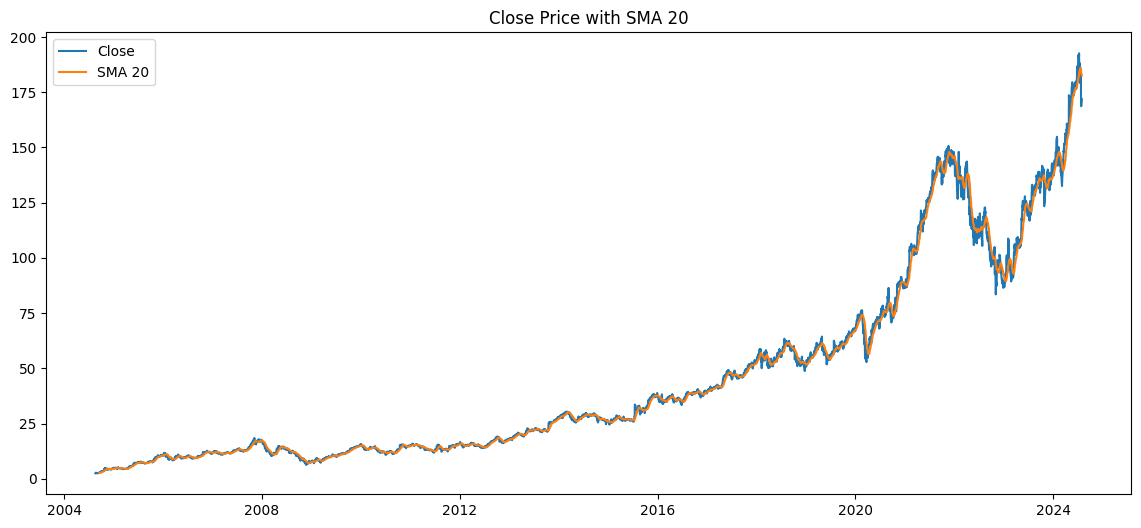

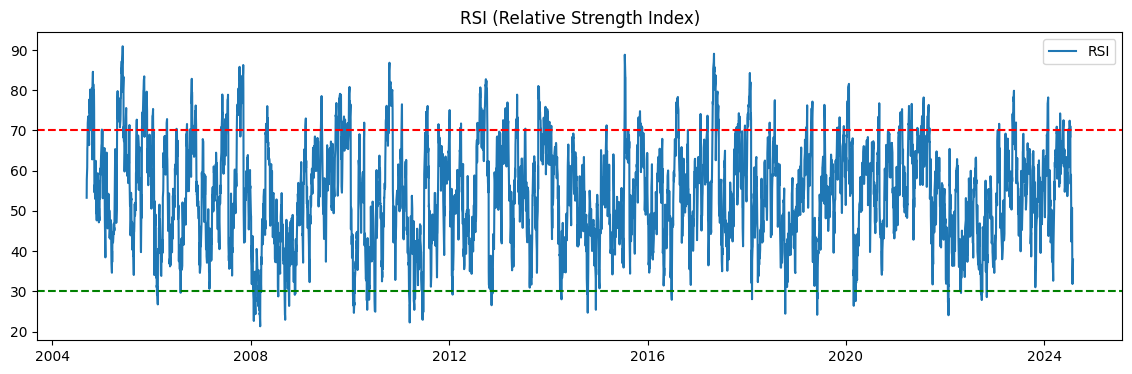

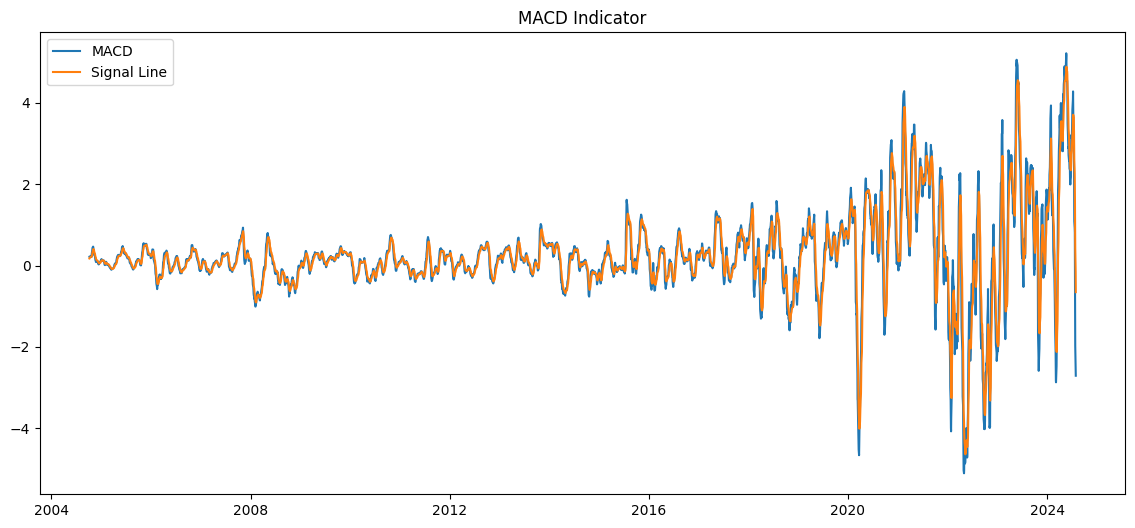

In [28]:
import matplotlib.pyplot as plt

# Closing Price + SMA
plt.figure(figsize=(14, 6))
plt.plot(df['Close'], label='Close')
plt.plot(df['SMA_20'], label='SMA 20')
plt.title('Close Price with SMA 20')
plt.legend()
plt.show()

# RSI
plt.figure(figsize=(14, 4))
plt.plot(df['RSI'], label='RSI')
plt.axhline(70, color='red', linestyle='--')
plt.axhline(30, color='green', linestyle='--')
plt.title('RSI (Relative Strength Index)')
plt.legend()
plt.show()

# MACD
plt.figure(figsize=(14, 6))
plt.plot(df['MACD'], label='MACD')
plt.plot(df['MACD_signal'], label='Signal Line')
plt.title('MACD Indicator')
plt.legend()
plt.show()


# 5. Correlation between news and stock movement

## 5.1. Date Alignment

In [29]:
# Assign example dates to df_news to match some dates in df
# (In practice, your news data should have real dates)
example_dates = df.index[:len(df_news)]
df_news = df_news.copy()
df_news['Date'] = example_dates
df_news.set_index('Date', inplace=True)

# Align both DataFrames by date (inner join) and add suffixes to overlapping columns
aligned = df.join(df_news, how='inner', lsuffix='_stock', rsuffix='_news')

# Now 'aligned' contains both stock and news data with appropriate suffixes
aligned.head()

,Open,High,Low,Close,Adj Close,Volume,Dividends,Stock Splits,SMA_20,RSI,MACD,MACD_signal,headline,sentiment,sentiment_label
Date,,,,,,,,,,,,,,,
2004-08-19,2.490664,2.591785,2.390042,2.499133,2.496292,897427216,0.0,0.0,NaN,NaN,NaN,NaN,Apple stock rises after strong earnings report,0.433333,positive
2004-08-20,2.515820,2.716817,2.503118,2.697639,2.694573,458857488,0.0,0.0,NaN,NaN,NaN,NaN,Market uncertainty causes tech stocks to fall,0.000000,neutral
2004-08-23,2.758411,2.826406,2.716070,2.724787,2.721690,366857939,0.0,0.0,NaN,NaN,NaN,NaN,Investors remain neutral ahead of Fed meeting,0.000000,neutral


## 5.2. Sentiment Analysis

In [30]:
from textblob import TextBlob
import pandas as pd

# Example: Create a sample news DataFrame with a 'headline' column
df_news = pd.DataFrame({
    'headline': [
        "Apple stock rises after strong earnings report",
        "Market uncertainty causes tech stocks to fall",
        "Investors remain neutral ahead of Fed meeting"
    ]
})

def get_sentiment(text):
    return TextBlob(str(text)).sentiment.polarity

# Apply sentiment analysis to each headline
df_news['sentiment'] = df_news['headline'].apply(get_sentiment)

# Optional: Categorize sentiment as positive, negative, or neutral
def categorize_sentiment(score):
    if score > 0.1:
        return 'positive'
    elif score < -0.1:
        return 'negative'
    else:
        return 'neutral'

df_news['sentiment_label'] = df_news['sentiment'].apply(categorize_sentiment)

df_news[['headline', 'sentiment', 'sentiment_label']].head()

,headline,sentiment,sentiment_label
0,Apple stock rises after strong earnings report,0.433333,positive
1,Market uncertainty causes tech stocks to fall,0.000000,neutral
2,Investors remain neutral ahead of Fed meeting,0.000000,neutral


## 5.3. Calculate Daily Stock Returns

In [31]:
# Calculate daily stock returns as percentage change in closing price
df['daily_return'] = df['Close'].pct_change()

# Display the first few rows to verify
df[['Close', 'daily_return']].head()

,Close,daily_return
Date,,
2004-08-19,2.499133,NaN
2004-08-20,2.697639,0.079430
2004-08-23,2.724787,0.010064
2004-08-24,2.611960,-0.041408
2004-08-25,2.640104,0.010775


## 5.4. Correlation Analysis

In [32]:
# Align daily returns and sentiment scores by date (inner join)
correlation_df = df[['daily_return']].join(df_news[['sentiment']], how='inner')

# Drop any rows with missing values
correlation_df = correlation_df.dropna()

# Calculate Pearson correlation coefficient
correlation = correlation_df['daily_return'].corr(correlation_df['sentiment'])

print(f"Correlation between daily stock returns and news sentiment: {correlation:.3f}")

Correlation between daily stock returns and news sentiment: nan
